<a href="https://colab.research.google.com/github/hyunseo-hy/FinEng/blob/main/K10_Index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import bs4
from urllib.request import urlopen, Request
import re
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def date_format(d):
  d = str(d).replace('-','.')
  yyyy = int(d.split('.')[0])
  mm = int(d.split('.')[1])
  dd = int(d.split('.')[2])

  this_date = dt.date(yyyy,mm,dd)
  return this_date

In [ ]:
url_float = "http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd=005930"
source = urlopen(url_float).read()
soup = bs4.BeautifulSoup(source, "lxml")

# 발행주식 수, 유동비율 추출
tmp = soup.find(id="cTB11").find_all("tr")[6].td.text
tmp = tmp.replace("\n", "").replace("\t","").replace("\t","")
tmp = re.split('/', tmp)
outstanding = int(tmp[0].replace(',',"").replace("주",""))
floating = float(tmp[1].replace("%",""))

In [ ]:
def stock_info(stock_cd):
  url_float = f"http://companyinfo.stock.naver.com/v1/company/c1010001.aspx?cmp_cd={stock_cd}"
  source = urlopen(url_float).read()
  soup = bs4.BeautifulSoup(source, "lxml")
  tmp = soup.find(id="cTB11").find_all("tr")[6].td.text
  tmp = tmp.replace("\n", "").replace("\t","").replace("\t","")
  tmp = re.split('/', tmp)

  outstanding = int(tmp[0].replace(',',"").replace("주",""))
  floating = float(tmp[1].replace("%",""))
  # //*[@id="pArea"]/div[1]/div/table/tbody/tr[1]/td/dl/dt[1]/span
  name = soup.find(id="pArea").find("span", class_="name").text

  k10_outstanding[stock_cd] = outstanding
  k10_floating[stock_cd] = floating
  k10_name[stock_cd] = name

In [ ]:
k10_component = ['005930', '000660', '068270', '005380', '207940',
                 '051910', '005490', '035420', '017670', '015760']

print(k10_component)
k10_outstanding = dict()
k10_floating = dict()
k10_name = dict()

for stock_cd in k10_component:
  k10_component
  stock_info(stock_cd)

In [ ]:
dates = list()
prices = list()

url_day = f"https://finance.naver.com/item/sise_day.nhn?code=005930"
req = Request(url_day, headers={'User-Agent': 'Mozilla/5.0'})
source = urlopen(req).read()
soup = bs4.BeautifulSoup(source, "lxml")
tmp = soup.find_all("span", class_="tah p10 gray03")
for i in range(len(tmp)):
  dates.append(tmp[i].get_text())
print(dates)

data_rows = soup.find_all("tr", attrs={"onmouseover": "mouseOver(this)"})
for row in data_rows:
    cols = row.find_all("td")
    if len(cols) >= 2:
        closing_price = int(cols[1].get_text().replace(',', '').strip())
        prices.append(closing_price)
print(prices)

In [ ]:
def historical_stock_naver(stock_cd, start_date="", end_date="", page_n=1, last_page=0):
  # date 변수타입 설정
  if start_date:
    start_date = date_format(start_date)
  else:
    start_date = dt.date.today()
  if end_date:
    end_date = date_format(end_date)
  else:
    end_date = dt.date.today()

  # url 소스 코드 읽기
  url_day = f"https://finance.naver.com/item/sise_day.nhn?code={stock_cd}&page={page_n}"
  dates = list()
  prices = list()
  req = Request(url_day, headers={'User-Agent': 'Mozilla/5.0'})
  source = urlopen(req).read()
  soup = bs4.BeautifulSoup(source, "lxml")

  #dates
  tmp = soup.find_all("span", class_="tah p10 gray03")
  for i in range(len(tmp)):
    dates.append(tmp[i].get_text())
  #prices
  data_rows = soup.find_all("tr", attrs={"onmouseover": "mouseOver(this)"})
  for row in data_rows:
      cols = row.find_all("td")
      if len(cols) >= 2:
          closing_price = int(cols[1].get_text().replace(',', '').strip())
          prices.append(closing_price)

  #dictionary 생성
  for n in range(len(dates)):
    if len(dates)>0:
      #Dates Process
      this_date = dates[n]
      this_date = date_format(this_date)
      if this_date <= end_date and this_date >= start_date:
        #Prices Process
        this_close = float(str(prices[n]).replace(',',''))
        #Save the dictionary
        historical_prices[this_date] = this_close
        if stock_cd == "005930":
         date_range.append(this_date)
      elif this_date < start_date:
        return historical_prices

  # page 처리
  if last_page == 0:
    last_page = soup.find("td", class_="pgRR").find("a")["href"]
    last_page = last_page.split("&")[1]
    last_page = last_page.split("=")[1]
    last_page = int(last_page)

  if page_n < last_page:
    page_n = page_n+1
    historical_stock_naver(stock_cd, start_date, end_date, page_n, last_page)

  return historical_prices

In [ ]:
k10_historical_prices = dict()
date_range=[]

for stock_cd in k10_component:
  historical_prices = dict()
  start_date = "2025-1-1"
  end_date="2026-1-1"
  print("진행 중")
  historical_stock_naver(stock_cd, start_date, end_date)
  print("완료!")
  k10_historical_prices[stock_cd] = historical_prices
df_k10_pr = pd.DataFrame(k10_historical_prices).sort_index(ascending=True)
print(df_k10_pr)

In [ ]:
print(df_k10_pr.isnull().sum())
df_k10_pr = df_k10_pr.fillna(method="ffill")
if df_k10_pr.isnull().values.any():
  df_k10_pr = df_k10_pr.fillna(method="bfill")
date_range.reverse()
print(date_range)

In [ ]:
tmp = {
    'Outstanding' : k10_outstanding,
    'Floating' : k10_floating,
    'Price' : df_k10_pr.iloc[0], #current price
    'Name' : k10_name
}
k10_info = pd.DataFrame(tmp)
k10_info["f Market Cap"] = k10_info['Outstanding'] * k10_info['Floating']*0.01*k10_info['Price']

k10_historical_mc = dict()
date_str = []
for i in range(len(date_range)):
  date_str.append(str(date_range[i]))

for i in range(len(date_range)):
  tmp = {
    'Outstanding' : k10_outstanding,
    'Floating' : k10_floating,
    'Price' : df_k10_pr.iloc[i], #current price
    'Name' : k10_name
}
  k10_historical_mc[date_str[i]] = k10_info['Outstanding'] * k10_info['Floating']*0.01*k10_info['Price']
print(k10_historical_mc)
df = pd.DataFrame(k10_historical_mc)
print(df)

In [ ]:
k10_mc = df_k10_pr*k10_info['Outstanding'] * k10_info['Floating']*0.01
k10_mc

In [ ]:
k10 = pd.DataFrame()
k10["K10 Market Cap"] = k10_mc.sum(axis=1)
k10["K10"] = k10['K10 Market Cap']/k10['K10 Market Cap'][0]*100

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(k10["K10"])
plt.legend(loc=0)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)

In [ ]:
def his_index_naver(index_cd, start_date = "", end_date="", page_n=1, last_page=0):
  if start_date:
    start_date = date_format(start_date)
  else:
    start_date = dt.date.today()

  if end_date:
    end_date = date_format(end_date)
  else:
    end_date = dt.date.today()

  naver_index = "https://finance.naver.com/sise/sise_index_day.naver?code=" + index_cd + "&page=" + str(page_n)
  source = urlopen(naver_index).read()
  source = bs4.BeautifulSoup(source,"lxml")
  dates = source.find_all("td", class_="date")
  prices = source.find_all("td", class_= "number_1")

  for n in range(len(dates)):
    if dates[n].text.split('.')[0].isdigit():
      #Dates Process
      this_date = dates[n].text
      this_date = date_format(this_date)
      if this_date <= end_date and this_date >= start_date:
        #Prices Process
        this_close = prices[n*4].text
        this_close = this_close.replace(',','')
        this_close = float(this_close)
        #Save the dictionary
        historical_prices[this_date] = this_close
      elif this_date < start_date:
        return historical_prices

  if last_page == 0:
    last_page = source.find("td", class_="pgRR").find("a")["href"]
    last_page = last_page.split("&")[1]
    last_page = last_page.split("=")[1]
    last_page = int(last_page)

  #Recall the next page
  if page_n < last_page:
    page_n = page_n+1
    his_index_naver(index_cd, start_date, end_date, page_n, last_page)

  return historical_prices

In [ ]:
historical_prices = dict()
kospi200 = his_index_naver("KPI200", "2025-1-1", "2026-1-1")
print(kospi200)
k200 = pd.DataFrame({"K200":kospi200})
k200 = k200/k200["K200"][0]*100

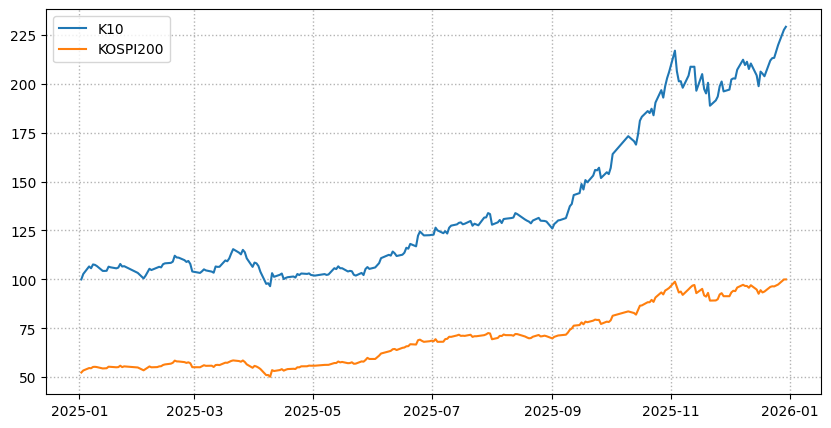

In [24]:
plt.figure(figsize=(10,5))
plt.plot(k10["K10"], label = "K10")
plt.plot(k200, label = "KOSPI200")
plt.legend(loc=0)
plt.grid(True, color="0.7", linestyle=":", linewidth=1)